In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline
from tqdm import tqdm
import seaborn as sns
from sklearn.model_selection import train_test_split
from keras.layers import Dense, Conv2D, Dropout, BatchNormalization, GlobalAveragePooling2D, MaxPooling2D, Input, Flatten
from keras.models import Sequential
from keras.optimizers import Adam
from keras_tqdm import TQDMNotebookCallback

Using TensorFlow backend.


In [2]:
np.random.seed(42)

In [174]:
data = pd.read_csv("./training.csv")
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7049 entries, 0 to 7048
Data columns (total 31 columns):
left_eye_center_x            7039 non-null float64
left_eye_center_y            7039 non-null float64
right_eye_center_x           7036 non-null float64
right_eye_center_y           7036 non-null float64
left_eye_inner_corner_x      2271 non-null float64
left_eye_inner_corner_y      2271 non-null float64
left_eye_outer_corner_x      2267 non-null float64
left_eye_outer_corner_y      2267 non-null float64
right_eye_inner_corner_x     2268 non-null float64
right_eye_inner_corner_y     2268 non-null float64
right_eye_outer_corner_x     2268 non-null float64
right_eye_outer_corner_y     2268 non-null float64
left_eyebrow_inner_end_x     2270 non-null float64
left_eyebrow_inner_end_y     2270 non-null float64
left_eyebrow_outer_end_x     2225 non-null float64
left_eyebrow_outer_end_y     2225 non-null float64
right_eyebrow_inner_end_x    2270 non-null float64
right_eyebrow_inner_end_y 

In [175]:
data = data.dropna()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2140 entries, 0 to 2283
Data columns (total 31 columns):
left_eye_center_x            2140 non-null float64
left_eye_center_y            2140 non-null float64
right_eye_center_x           2140 non-null float64
right_eye_center_y           2140 non-null float64
left_eye_inner_corner_x      2140 non-null float64
left_eye_inner_corner_y      2140 non-null float64
left_eye_outer_corner_x      2140 non-null float64
left_eye_outer_corner_y      2140 non-null float64
right_eye_inner_corner_x     2140 non-null float64
right_eye_inner_corner_y     2140 non-null float64
right_eye_outer_corner_x     2140 non-null float64
right_eye_outer_corner_y     2140 non-null float64
left_eyebrow_inner_end_x     2140 non-null float64
left_eyebrow_inner_end_y     2140 non-null float64
left_eyebrow_outer_end_x     2140 non-null float64
left_eyebrow_outer_end_y     2140 non-null float64
right_eyebrow_inner_end_x    2140 non-null float64
right_eyebrow_inner_end_y 

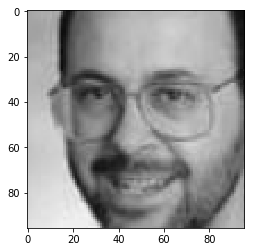

In [173]:
px_map = np.reshape(np.array([int(pixel) for pixel in data.Image[7041].split(" ")]), (96, 96))
image = Image.fromarray(px_map)
plt.imshow(image)

In [19]:
'''for i in tqdm(range(len(data))):
    px_map = np.reshape(np.array([int(pixel) for pixel in data.Image[i].split(" ")]), (96, 96))
    image = Image.fromarray(px_map)
    image = image.convert('RGB')
    image.save('./images/'+str(i)+'.bmp')'''

100%|██████████████████████████████████████████████████████████████████████████████| 7049/7049 [04:24<00:00, 27.44it/s]


In [176]:
X = []
for row in tqdm(data.Image):
    X.append([int(pixel) for pixel in row.split(" ")])
X = np.reshape(np.array(X), (-1, 96, 96, 1))
X = X/255
print(X.shape)

100%|██████████████████████████████████████████████████████████████████████████████| 2140/2140 [00:23<00:00, 92.85it/s]


(2140, 96, 96, 1)


In [114]:
data.index[data.left_eye_inner_corner_x.isnull(),]

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\pandas\core\indexes\base.py:1754: FutureWarning: in the future, boolean array-likes will be handled as a boolean array index
  result = getitem(key)


Int64Index([0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
            ...
            0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
           dtype='int64', length=7049)

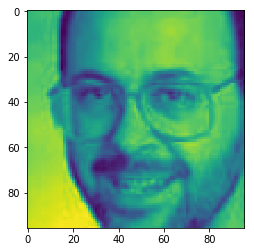

In [115]:
plt.imshow(X[7041][0])

C:\Users\abjilani\AppData\Local\Continuum\Anaconda3\envs\dlnd-tf-lab\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


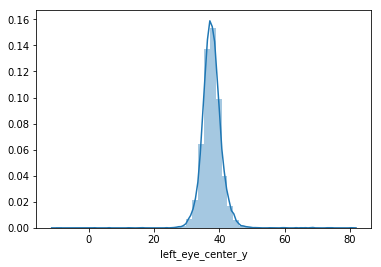

In [21]:
sns.distplot(data.left_eye_center_y.fillna(-10))

In [116]:
data = data.fillna(-10)
data.columns

Index(['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y', 'Image'],
      dtype='object')

In [177]:
y = data[['left_eye_center_x', 'left_eye_center_y', 'right_eye_center_x',
       'right_eye_center_y', 'left_eye_inner_corner_x',
       'left_eye_inner_corner_y', 'left_eye_outer_corner_x',
       'left_eye_outer_corner_y', 'right_eye_inner_corner_x',
       'right_eye_inner_corner_y', 'right_eye_outer_corner_x',
       'right_eye_outer_corner_y', 'left_eyebrow_inner_end_x',
       'left_eyebrow_inner_end_y', 'left_eyebrow_outer_end_x',
       'left_eyebrow_outer_end_y', 'right_eyebrow_inner_end_x',
       'right_eyebrow_inner_end_y', 'right_eyebrow_outer_end_x',
       'right_eyebrow_outer_end_y', 'nose_tip_x', 'nose_tip_y',
       'mouth_left_corner_x', 'mouth_left_corner_y', 'mouth_right_corner_x',
       'mouth_right_corner_y', 'mouth_center_top_lip_x',
       'mouth_center_top_lip_y', 'mouth_center_bottom_lip_x',
       'mouth_center_bottom_lip_y']]
y = np.array(y)

In [178]:
 y = (y - 48) / 48

In [179]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.15, random_state = 42)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(1819, 96, 96, 1) (321, 96, 96, 1) (1819, 30) (321, 30)


In [180]:
cnn = Sequential()
cnn.add(Conv2D(32, (3,3), input_shape = (96, 96, 1), padding='same', activation='relu'))
cnn.add(MaxPooling2D(pool_size = (3,3)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(64, (2,2), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(BatchNormalization())

cnn.add(Conv2D(128, (2,2), activation='relu', padding='same'))
cnn.add(MaxPooling2D((2,2)))
cnn.add(BatchNormalization())

cnn.add(GlobalAveragePooling2D())
# cnn.add(Flatten())

cnn.add(Dense(500, activation='relu'))
cnn.add(Dense(32, activation='relu'))
# cnn.add(Dropout(0.5))
cnn.add(Dense(y.shape[1]))

cnn.compile(loss='mean_squared_error', metrics=['mean_squared_error'], optimizer='adam')

cnn.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_82 (Conv2D)           (None, 96, 96, 32)        320       
_________________________________________________________________
max_pooling2d_70 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
batch_normalization_54 (Batc (None, 32, 32, 32)        128       
_________________________________________________________________
conv2d_83 (Conv2D)           (None, 32, 32, 64)        8256      
_________________________________________________________________
max_pooling2d_71 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
batch_normalization_55 (Batc (None, 16, 16, 64)        256       
_________________________________________________________________
conv2d_84 (Conv2D)           (None, 16, 16, 128)       32896     
__________

In [185]:
cbs = [TQDMNotebookCallback()]
train_performance = cnn.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test),
                           callbacks=cbs)

Train on 1819 samples, validate on 321 samples
Epoch 1/10
1819/1819 [==============================] - ETA: 22s - loss: 0.0022 - mean_squared_error: 0.0022 - ETA: 12s - loss: 0.0021 - mean_squared_error: 0.0021 - ETA: 10s - loss: 0.0021 - mean_squared_error: 0.0021 - ETA: 9s - loss: 0.0021 - mean_squared_error: 0.0021  - ETA: 8s - loss: 0.0022 - mean_squared_error: 0.0022 - ETA: 7s - loss: 0.0022 - mean_squared_error: 0.0022

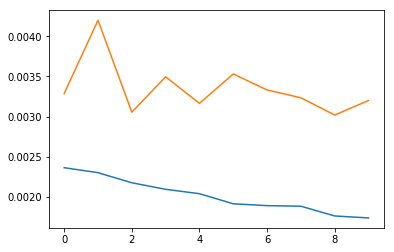

In [186]:
plt.plot(train_performance.history['loss'])
plt.plot(train_performance.history['val_loss'])
plt.show()

In [45]:
len(y[0,])
for i in range(int(len(y[0,])/2)):
    print((int(y[0,i]),int(y[0,i+1])))

(66, 39)
(39, 30)
(30, 36)
(36, 59)
(59, 39)
(39, 73)
(73, 39)
(39, 36)
(36, 37)
(37, 23)
(23, 37)
(37, 56)
(56, 29)
(29, 80)
(80, 32)


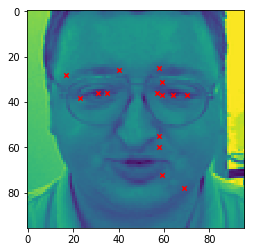

In [104]:
r = 50
base_img = X[r][0]
plt.imshow(base_img)
for i in range(int(len(y[r,])/2)):
    plt.scatter(int(96 - y[r,i]), int(y[r,i+1]), marker = 'x', s = 20, c='red')